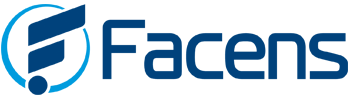
# TCC - Ciências de Dados - Turma 2020/1
## Sales Forecast

*   Louise Constantino - 203071
*   Luiza Constantino  - 203087

# Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import re

from pylab import rcParams

import itertools
from itertools import product

from tqdm import tqdm_notebook

from fbprophet import Prophet

%pip install neuralprophet
from neuralprophet import NeuralProphet

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import add_changepoints_to_plot

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Interactive methods
from fbprophet.plot import plot_plotly, plot_components_plotly 


import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import seaborn as sns
import statsmodels.api as sm

# Carrega DataSet

In [ ]:
with open('AgroSales_new.csv', 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large


df = pd.read_csv('AgroSales_new.csv', encoding=result['encoding'], sep=';')

In [ ]:
df.head()

referencia        data      ds_cultura      qt_volume
0  2021-07-01  2021-07-01  CANA-DE-AÇUCAR   14550.000000
1  2017-10-01  2017-10-27            SOJA  122937.999977
2  2017-11-01  2017-11-21            SOJA   48311.999991
3  2018-04-01  2018-04-26            SOJA  135819.999976
4  2018-11-01  2018-11-10           MILHO   16679.999993

# Tratamento dos Dados e Análise Exploratória

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3581 entries, 0 to 3580
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   referencia  3581 non-null   object 
 1   data        3581 non-null   object 
 2   ds_cultura  3581 non-null   object 
 3   qt_volume   3581 non-null   float64
dtypes: float64(1), object(3)
memory usage: 112.0+ KB


## Conversão tipo de Dados

In [ ]:
df.qt_volume = df.qt_volume.astype(float)
df.data= pd.to_datetime(df.data)
df.referencia= pd.to_datetime(df.referencia)

Checa Resultado após conversão

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3581 entries, 0 to 3580
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   referencia  3581 non-null   datetime64[ns]
 1   data        3581 non-null   datetime64[ns]
 2   ds_cultura  3581 non-null   object        
 3   qt_volume   3581 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 112.0+ KB


In [ ]:
df.describe()

qt_volume
count  3.581000e+03
mean   6.253430e+04
std    9.948681e+04
min    4.800000e+00
25%    7.380000e+03
50%    2.355000e+04
75%    7.319800e+04
max    1.126710e+06

## Dados Faltantes

In [ ]:
df.isnull().sum()

referencia    0
data          0
ds_cultura    0
qt_volume     0
dtype: int64

Não há dados faltantes no DataSet, pois registros em data que não trata-se de feriado é normal

In [ ]:
#Seta Data como índice do Data Frame
df.set_index('data', inplace=True)

## Distribuição do Volume

Distribuição Total por Cultura - Soja concentra maior parte do volume total

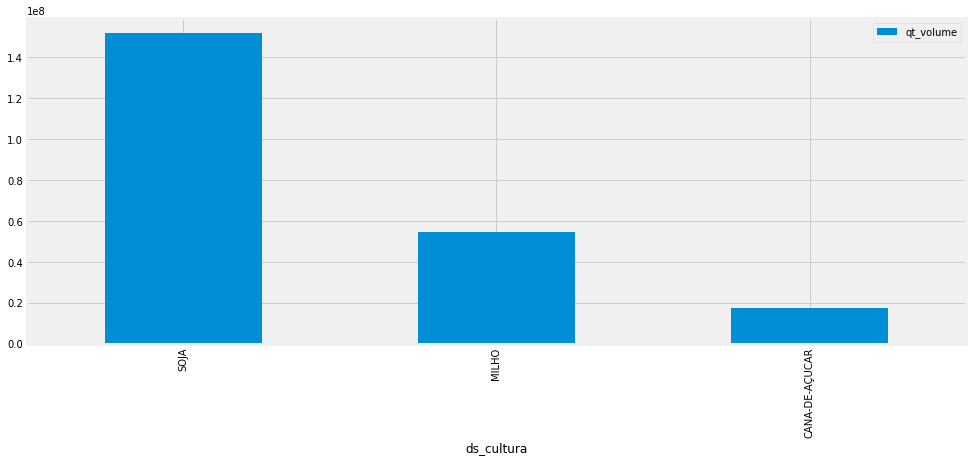

In [ ]:
  df.groupby('ds_cultura').qt_volume.sum().to_frame().sort_values('qt_volume', ascending=False ).plot(kind='bar')
  plt.gcf().set_size_inches(15, 6)
  plt.show()

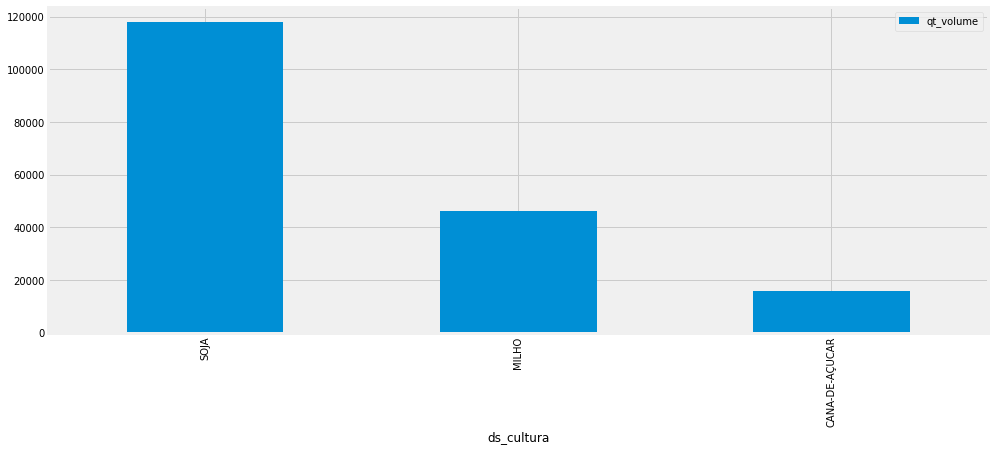

In [ ]:
df.groupby('ds_cultura').qt_volume.mean().to_frame().sort_values('qt_volume', ascending=False ).plot(kind='bar')
plt.gcf().set_size_inches(15, 6)
plt.show()

Quantidade de registros por cultura

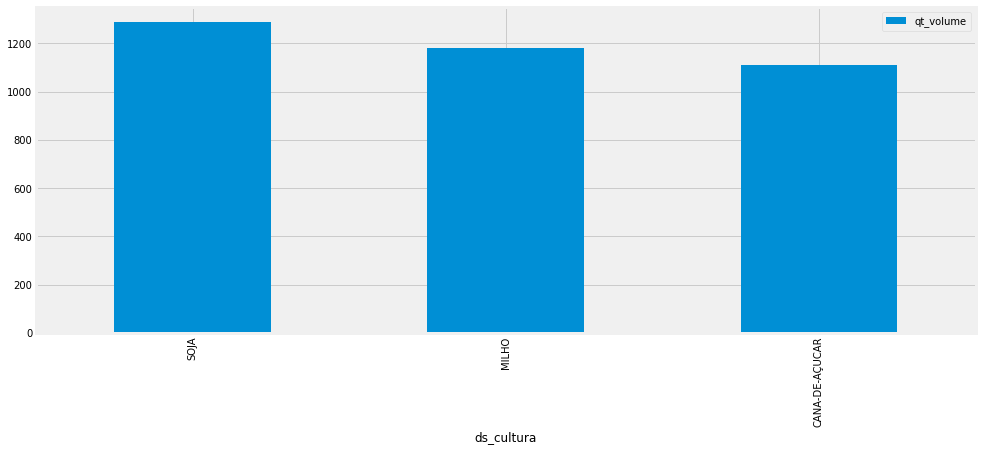

In [ ]:
  df.groupby('ds_cultura').qt_volume.count().to_frame().sort_values('qt_volume', ascending=False ).plot(kind='bar')
  plt.gcf().set_size_inches(15, 6)
  plt.show()

In [ ]:
l_cultura = df.ds_cultura.unique()

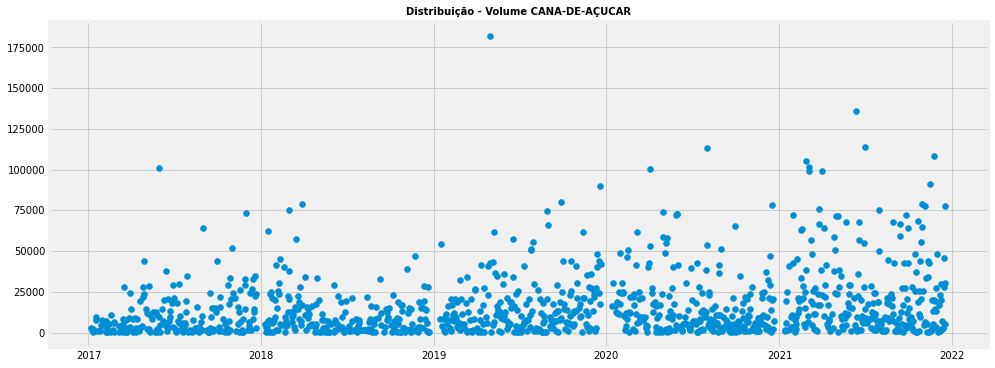

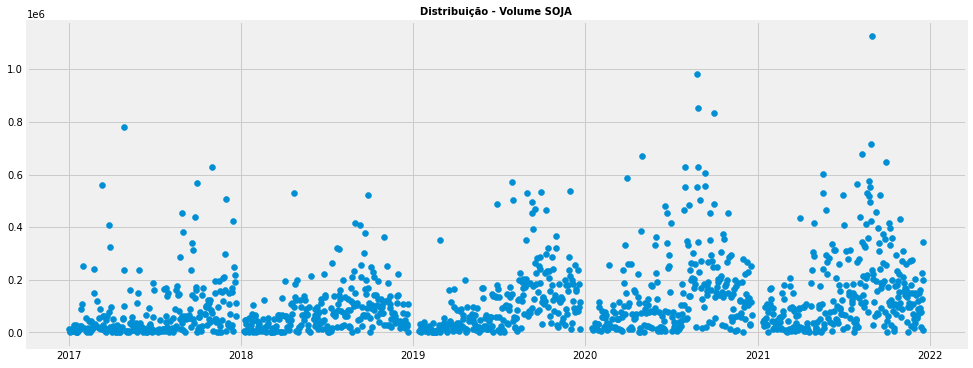

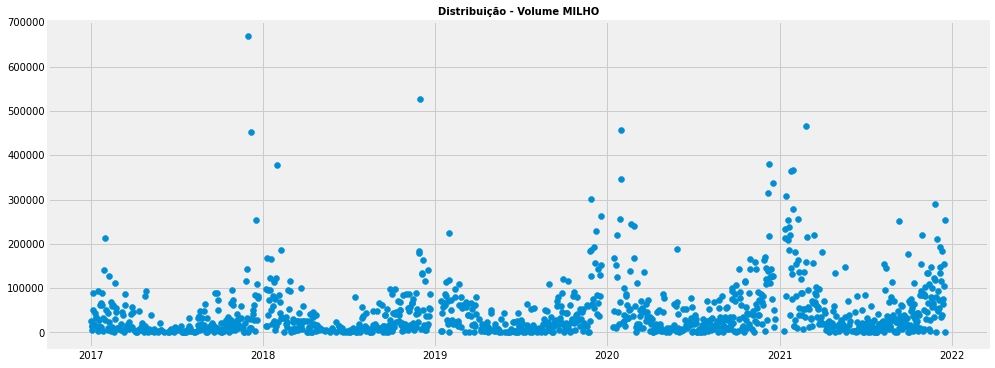

In [ ]:
for cultura in l_cultura:
  plt.figure(figsize=(15,6))
  data = df[df.ds_cultura == cultura]
  plt.title('Distribuição - Volume {}'.format(cultura), size=10, fontweight='bold')
  plt.scatter(data.index, data.qt_volume)
  plt.show()

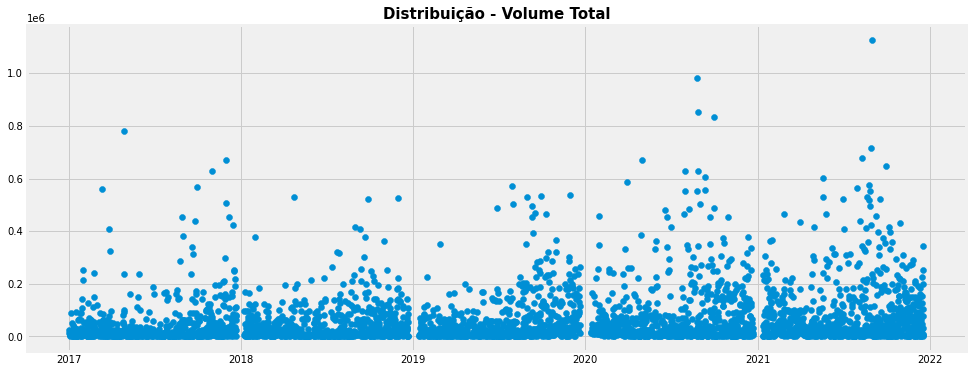

In [ ]:
plt.figure(figsize=(15,6))
plt.title('Distribuição - Volume Total', size=15, fontweight='bold')
plt.scatter(df.index, df.qt_volume)
plt.show()

Nota-se outliers em todas culturas e total. Removeremos os outliers de cada cultura

In [ ]:
df = df[ (df.qt_volume <= 0.3*1000000) ] # Removendo outliers de Soja
df = df[ ((df.qt_volume <= 150000) & (df.ds_cultura == 'MILHO')) | (df.ds_cultura != 'MILHO') ] # Removendo outliers de Milho
df = df[ ((df.qt_volume <= 50000) & (df.ds_cultura == 'CANA-DE-AÇUCAR')) | (df.ds_cultura != 'CANA-DE-AÇUCAR') ] # Removendo outliers de Cana de Açucar

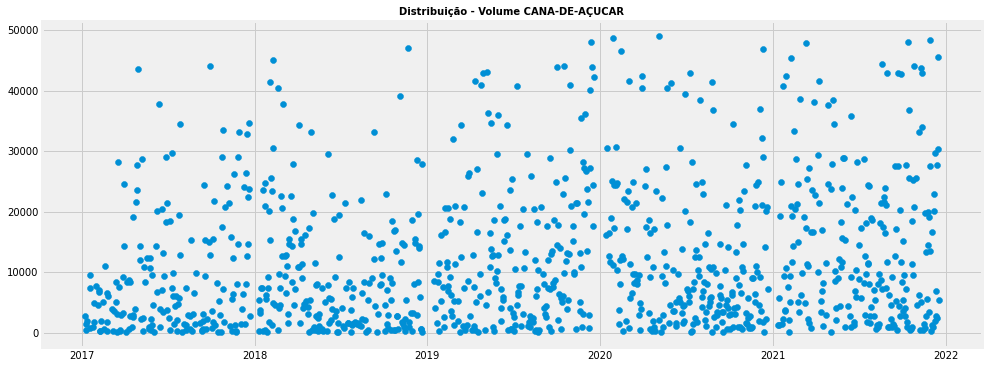

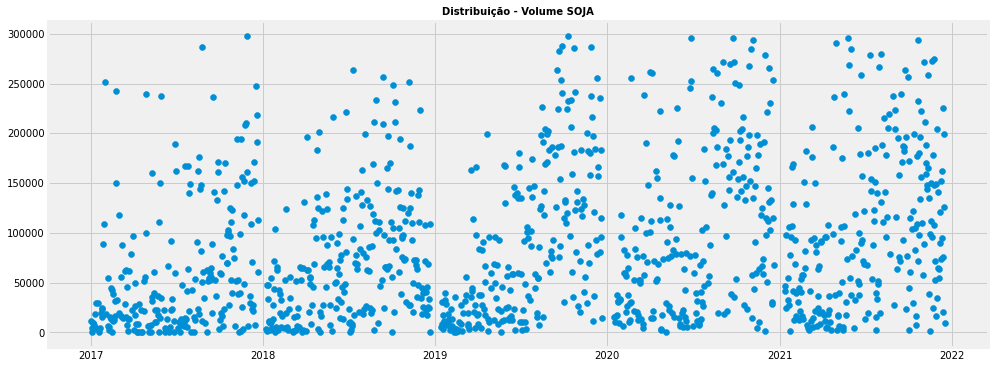

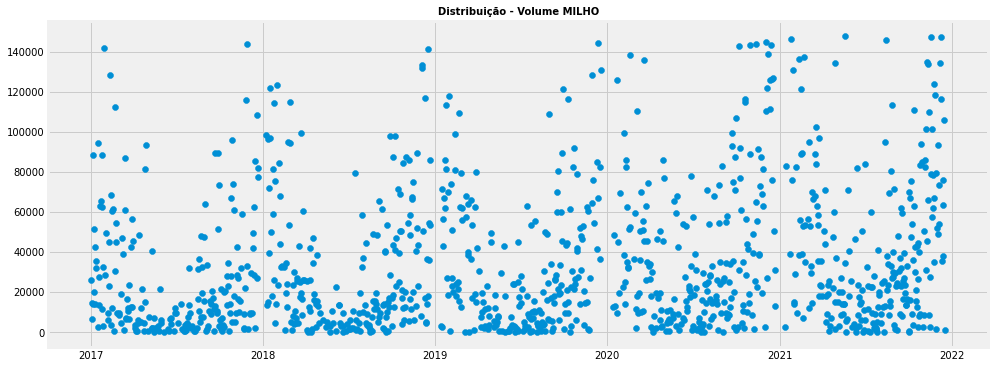

In [ ]:
for cultura in l_cultura:
  plt.figure(figsize=(15,6))
  data = df[df.ds_cultura == cultura]
  plt.title('Distribuição - Volume {}'.format(cultura), size=10, fontweight='bold')
  plt.scatter(data.index, data.qt_volume)
  plt.show()

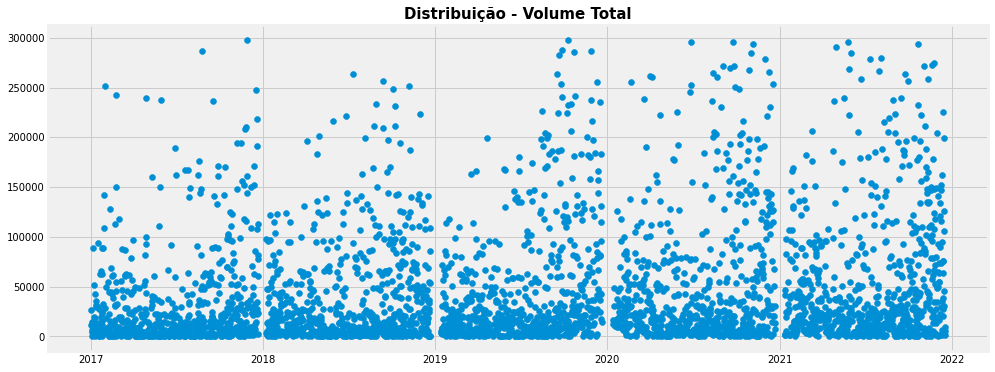

In [ ]:
plt.figure(figsize=(15,6))
plt.title('Distribuição - Volume Total', size=15, fontweight='bold')
plt.scatter(df.index, df.qt_volume)
plt.show()

## Identificando Tendência e Sazonalidade
  

In [ ]:
# Totaliza por Mês
data_month = df.groupby(['referencia', 'ds_cultura'])['qt_volume'].sum().to_frame().reset_index().set_index('referencia')

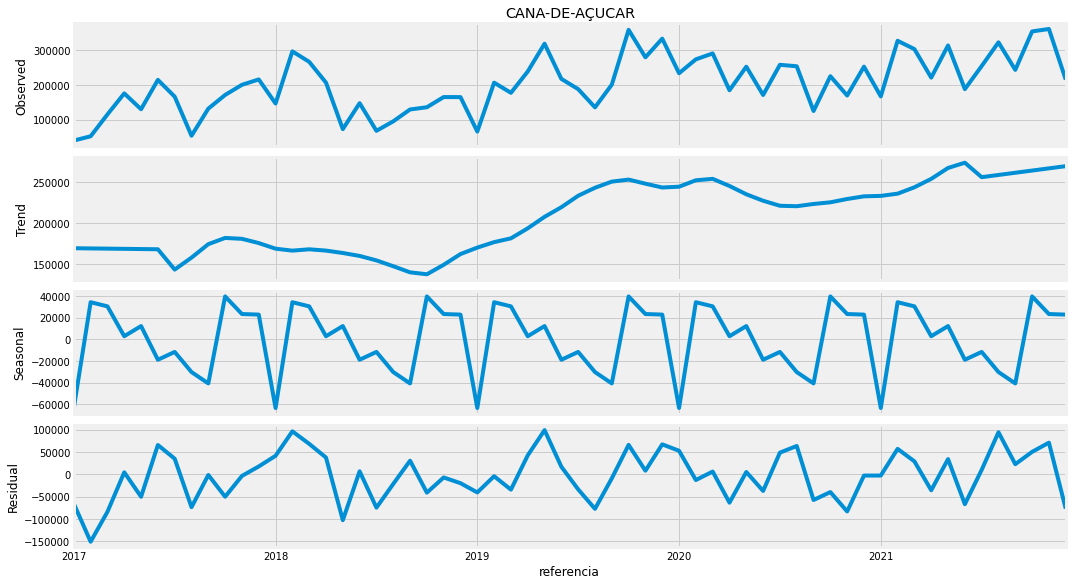

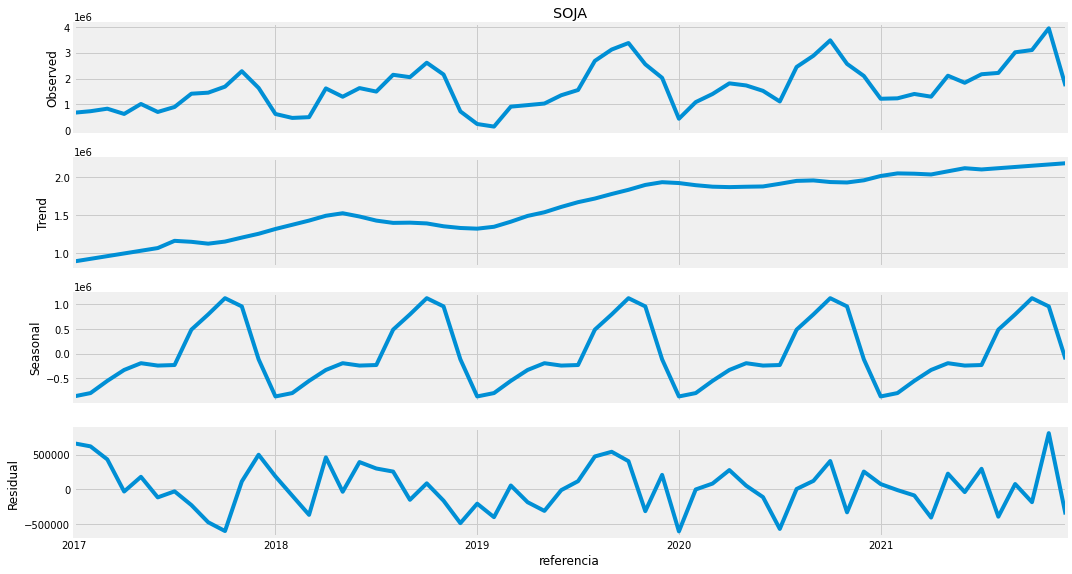

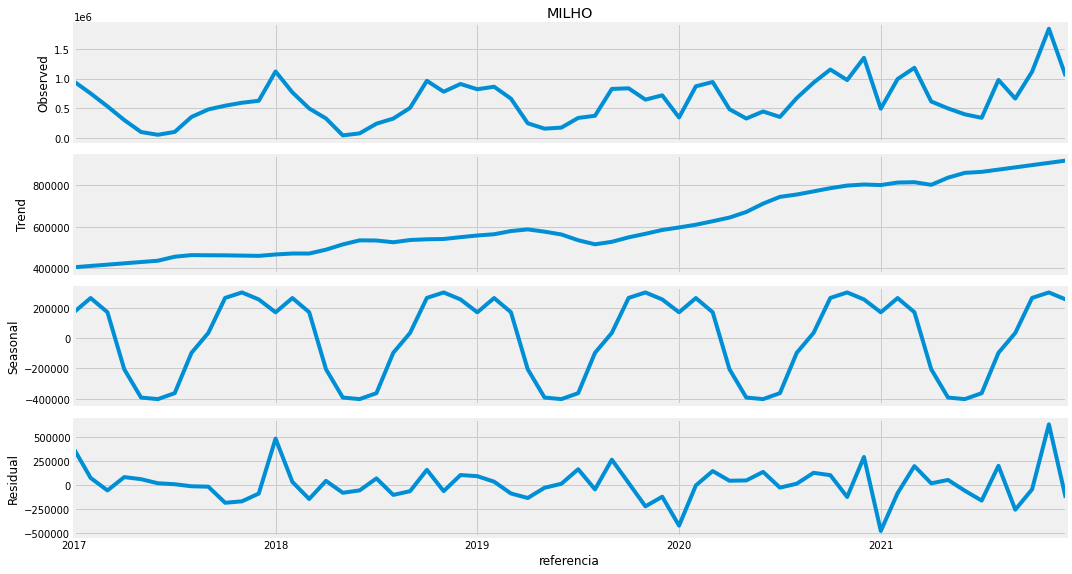

In [ ]:
rcParams['figure.figsize'] = 15, 8
for cultura in l_cultura:  
  data = data_month[data_month.ds_cultura == cultura][['qt_volume']]
  decomposition = sm.tsa.seasonal_decompose(data, model='additive',freq=12, extrapolate_trend = 12)  
  fig = decomposition.plot()
  axes = fig.get_axes()
  
  axes[0].set_title(cultura)

Todas as culturas apresentam tendência crescente e sazonalidade

In [ ]:
# Totaliza por Data
data = df.groupby(['data', 'ds_cultura'])['qt_volume'].sum().to_frame()
data.sort_index(inplace=True)
data = data.reset_index().set_index('data')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3323 entries, 2017-01-02 to 2021-12-18
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ds_cultura  3323 non-null   object 
 1   qt_volume   3323 non-null   float64
dtypes: float64(1), object(1)
memory usage: 77.9+ KB


In [ ]:
data.describe()

qt_volume
count    3323.000000
mean    44855.405088
std     57960.529688
min         4.800000
25%      6595.999999
50%     20469.999998
75%     60121.999985
max    297751.999778

# Predições

Cria função para gerar avaliação dos modelos

In [ ]:
df_metrics = pd.DataFrame(columns=['Model','Cultura','MAE','RMSE'])

In [ ]:
def metrics_aval(df_aval, model_name, cat, y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  
  mae  = round(mean_absolute_error(y_true, y_pred),2)
  mse  = mean_squared_error(y_true, y_pred)
  rmse = round(np.sqrt(mse),2)

  df_aval = df_aval.append({'Model':model_name, 'Cultura':cat, 'MAE':mae, 'RMSE':rmse}, ignore_index=True)

  return df_aval

### Treino e Teste
    - Treino: Dados anteriores a 08/2021
    - Teste: Dados 08/2021

In [ ]:
dt_corte = pd.to_datetime('2021-08-31')
train = data[data.index < dt_corte]
test  = data[data.index >= dt_corte]

## XGBOOST

### Criar recursos de série temporal

In [ ]:
def create_features(df, label=None):
  df['date'] = df['data']
  df['dayofweek'] = df['data'].dt.dayofweek
  df['quarter'] = df['data'].dt.quarter
  df['month'] = df['data'].dt.month
  df['year'] = df['data'].dt.year
  df['dayofyear'] = df['data'].dt.dayofyear
  df['dayofmonth'] = df['data'].dt.day
  df['weekofyear'] = df['data'].dt.weekofyear
  X = df[['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
  
  if label:
    y = df[label]
  
  return X, y  
  return X

In [ ]:
def adjust_features(f_train, f_test):
  X_train, y_train = create_features(f_train, label='qt_volume')
  X_test, y_test = create_features(f_test, label='qt_volume')

  return X_train, y_train, X_test, y_test

### Tuning de hiperparâmetros

In [ ]:
def xgboost_gs(cat, train, test):

  df_train = train[train.ds_cultura == cat].groupby('data').qt_volume.sum().reset_index()  
  df_test = test[test.ds_cultura == cat].groupby('data').qt_volume.sum().reset_index()  

  #Ajusta treino e teste com recursos de série temporal
  X_train, y_train, X_test, y_test = adjust_features(df_train, df_test)

  params = {
      'min_child_weight': [4,5,6],
      'gamma': [i / 10.0 for i in range(2, 6)],
      'subsample': [i / 10.0 for i in range(6, 11)],
      'colsample_bytree': [i / 10.0 for i in range(6, 11)],
      'max_depth': [5, 9],
      'eta':[0.3],
      'eval_metric': ['rmse']
  }

  xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
  grid = GridSearchCV(xgb_reg, params)
  grid.fit(X_train, y_train)
  gridcv_xgb = grid.best_estimator_
  print(grid.best_estimator_)

  return grid, X_test, df_train, df_test

In [ ]:
def predict(model_fit, df_train, df_test, test_X, dt_corte):
  
  df_test['Prediction'] = model_fit.predict(test_X)
  df_all = pd.concat([df_test, df_train], sort=False)
  df_all.set_index('dt_referencia', inplace=True)
  df_all = df_all[df_all.date >= dt_corte]
  _ = df_all[['qt_volume','Prediction']].plot(figsize=(15, 5))

  return df_test

XGBRegressor(colsample_bytree=0.6, eta=0.3, eval_metric='rmse', gamma=0.2,
             max_depth=5, min_child_weight=6, nthread=-1,
             objective='reg:squarederror', subsample=0.6)
XGBRegressor(colsample_bytree=0.6, eta=0.3, eval_metric='rmse', gamma=0.2,
             max_depth=5, min_child_weight=6, nthread=-1,
             objective='reg:squarederror', subsample=0.7)
XGBRegressor(colsample_bytree=0.6, eta=0.3, eval_metric='rmse', gamma=0.2,
             max_depth=5, min_child_weight=6, nthread=-1,
             objective='reg:squarederror', subsample=0.9)


Model         Cultura       MAE      RMSE
0  XGBOOST  CANA-DE-AÇUCAR  11102.70  14075.16
1  XGBOOST            SOJA  60755.23  73172.46
2  XGBOOST           MILHO  30636.18  37867.43

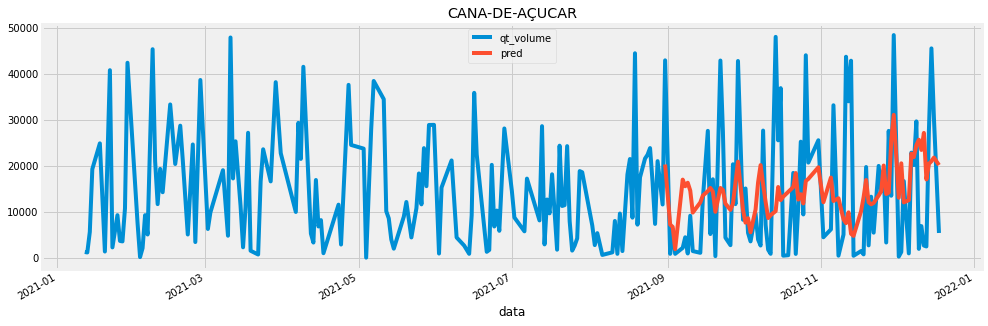

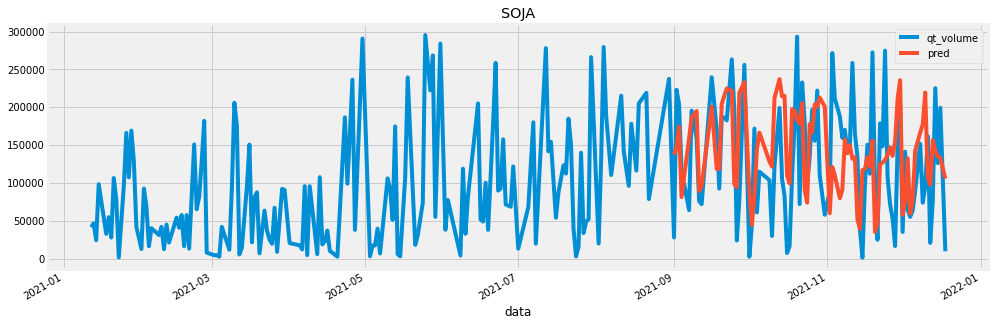

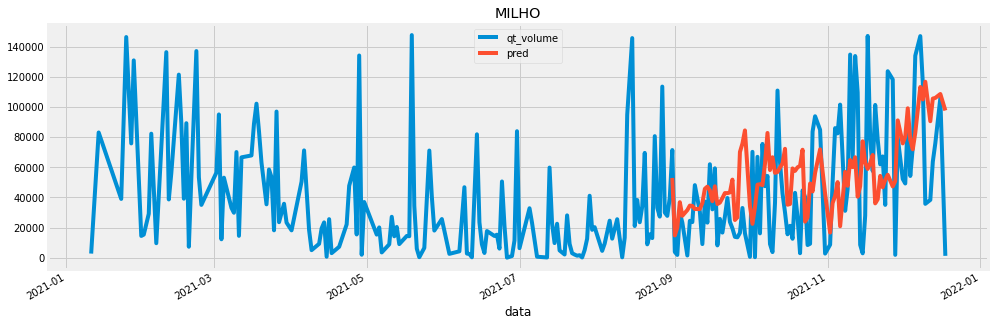

In [ ]:
for cultura in l_cultura:   

  #Ajusta o modelo
  model, X_test, df_train, df_test  = xgboost_gs(cultura, train, test)

  #Predição
  df_test['pred'] = model.predict(X_test)
  df_all = pd.concat([df_test, df_train], sort=False)
  df_all.set_index('data', inplace=True)
  df_all = df_all[df_all.date >= '2021-01-01']
  _ = df_all[['qt_volume','pred']].plot(figsize=(15, 5), title=cultura)

  #Avaliação do modelo
  df_metrics = metrics_aval(df_metrics, 'XGBOOST', cultura, y_true=df_test['qt_volume'], y_pred=df_test['pred'])

df_metrics

## PROPHET


O Profeta precisa de um tipo de quadro de dados muito específico para funcionar. 
O que precisamos é:
- Coluna de data como ds.
- Coluna de valor como y.

### Modelo Básico

In [ ]:
def basic_prophet(cat, df_train, df_test, df_metrics):

  df_train = df_train[df_train.ds_cultura == cat].groupby('data').qt_volume.sum().reset_index()
  df_train.columns = ["ds", "y"]

  df_test = df_test[df_test.ds_cultura == cat].groupby('data').qt_volume.sum().reset_index()
  df_test.columns = ["ds", "y"]

  model= Prophet()
  model.fit(df_train)

  forecast = model.predict(df_test)

  #Avaliação do modelo
  df_metrics = metrics_aval(df_metrics, 'BASIC_PROPHET', cat, y_true=df_test.y, y_pred=forecast.yhat)

  return model, forecast, df_metrics

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


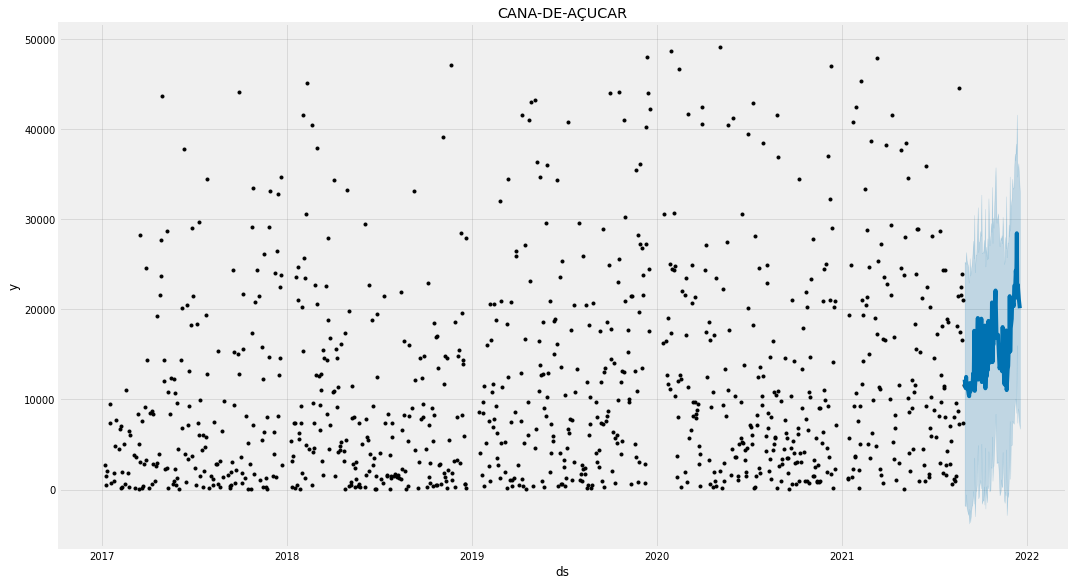

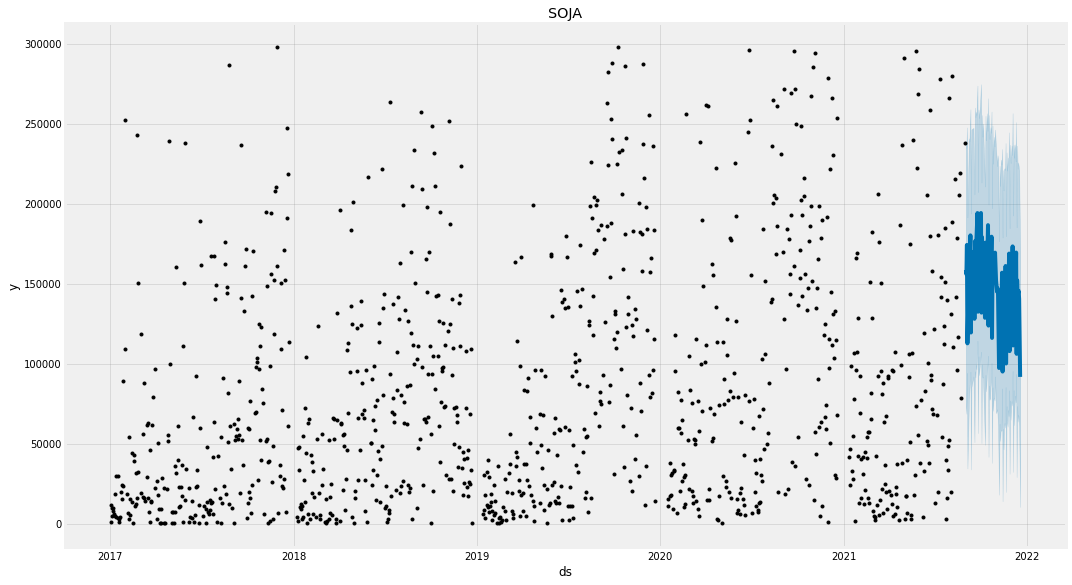

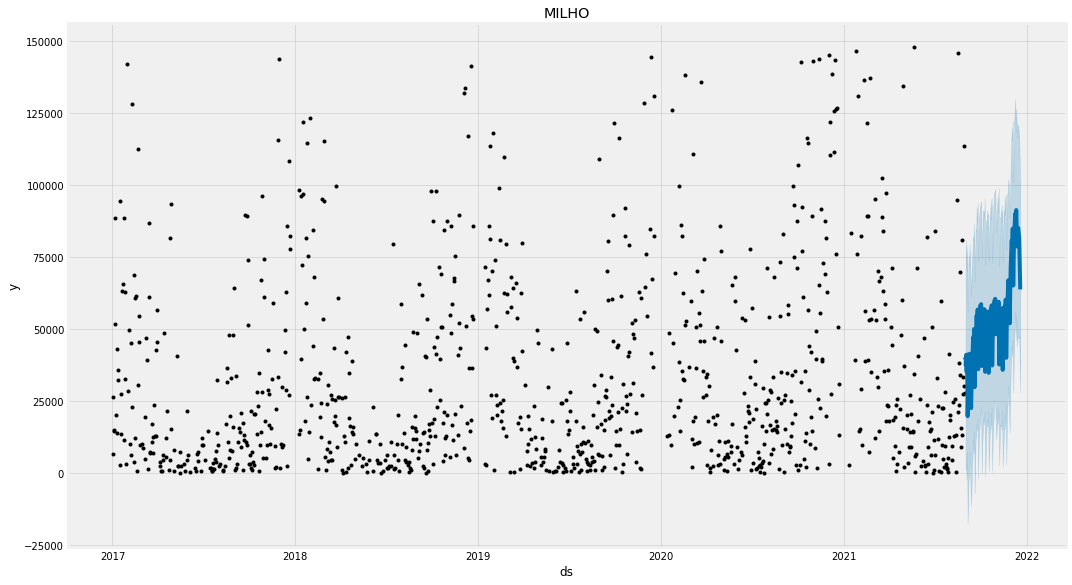

In [ ]:
#treina e testa por cultura
l_cultura = df.ds_cultura.unique()

for cultura in l_cultura:
  model, forecast, df_metrics = basic_prophet(cultura, train, test, df_metrics)
  forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()  
  sales_forecast_plot = model.plot(forecast, figsize=(15,8))  
  ax = sales_forecast_plot.gca()
  ax.set_title(cultura)
  
  plot_components_plotly(model, forecast)

### Ajuste de Parametros e Cross Validation

In [ ]:
def performance_cv(model, initial, days):
   df_cv = cross_validation(model, initial=f'{initial} days', period=f'{days} days', horizon =f'{days} days')
   return df_cv

In [ ]:
def param_prophet(cat, df_train, df_test, df_metrics):

  df_train = df_train[df_train.ds_cultura == cat].groupby('data').qt_volume.sum().reset_index()
  df_train.columns = ["ds", "y"]

  df_test = df_test[df_test.ds_cultura == cat].groupby('data').qt_volume.sum().reset_index()
  df_test.columns = ["ds", "y"]

  initial_days = len(df_train)
  period_days = len(df_test)

  model =  Prophet( 
      seasonality_mode="multiplicative",
      yearly_seasonality=True,
      weekly_seasonality=False,
      daily_seasonality=False
  )

  model.fit(df_train)

  forecast = model.predict(df_test)


  return model, forecast, initial_days, period_days, df_metrics

In [ ]:
for cultura in l_cultura:

  model, forecast, initial, prev_days, df_metrics = param_prophet(cultura, train, test, df_metrics)

  df_cv = performance_cv(model, initial, prev_days)

  df_p = performance_metrics(df_cv)
  df_p = df_p.mean().to_frame()

  mae = round(df_p[df_p.index == 'mae'][0][0],2)
  mse = round(df_p[df_p.index == 'mse'][0][0],2)
  rmse = round(df_p[df_p.index == 'rmse'][0][0],2)

  # Avaliação do Modelo
  df_metrics = df_metrics.append({'Model': 'MANUAL_PROPHET', 'Cultura':cultura, 'MAE':mae, 'RMSE':rmse}, ignore_index=True)

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-11-05 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-02 00:00:00 and 2021-05-31 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-10-21 00:00:00 and 2021-05-25 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

### Tuning de hiperparâmetros

In [ ]:
grid_param = {  
    "changepoint_prior_scale": [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['multiplicative'],
    'yearly_seasonality' : [True, False],
    'daily_seasonality' : [True, False]
}

In [ ]:
all_params = [dict(zip(grid_param.keys(), v)) for v in itertools.product(*grid_param.values())]
rmses = []

In [ ]:
df_best = pd.DataFrame(columns= ['ds_cultura','params'])

for cultura in l_cultura: 

  rmses.clear() 

  for params in all_params:
      
    df_train = train[train.ds_cultura == cultura].groupby('data').qt_volume.sum().reset_index()
    df_train.columns = ["ds", "y"]

    df_test = test[test.ds_cultura == cultura].groupby('data').qt_volume.sum().reset_index()
    df_test.columns = ["ds", "y"]

    prev_days = len(df_test)

    model = Prophet(**params).fit(df_train)

    df_cv = cross_validation(model, horizon =f'{prev_days} days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

  tuning_results = pd.DataFrame(all_params)
  #print('index', cultura, np.argmin(rmses))
  best_params = all_params[np.argmin(rmses)]

  df_best = df_best.append({'ds_cultura':cultura, 'params':best_params}, ignore_index = True)
  print(cultura,  best_params)

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 31 forecasts with cutoffs between 2018-01-10 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:Making 33 forecasts with cutoffs between 2017-10-19 00:00:00 and 2021-06-08 00:00:00


  0%|          | 0/33 [00:00<?, ?it/s]

CANA-DE-AÇUCAR {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'daily_seasonality': False}


INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-18 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:fbprophet:Making 30 forecasts with cutoffs between 2017-10-19 12:00:00 and 2021-05-31 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

SOJA {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'daily_seasonality': True}


INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-01-28 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:fbprophet:Making 28 forecasts with cutoffs between 2017-10-23 12:00:00 and 2021-05-25 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

MILHO {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'daily_seasonality': False}


In [ ]:
def tunning_prophet(cat, df_train, df_test, df_best_param, df_metrics):

  df_train = df_train[df_train.ds_cultura == cat].groupby('data').qt_volume.sum().reset_index()
  df_train.columns = ["ds", "y"]
  
  df_test = df_test[df_test.ds_cultura == cat].groupby('data').qt_volume.sum().reset_index()
  df_test.columns = ["ds", "y"]

  # Busca best params para cultura informada
  params = df_best_param[df_best_param.index == cat]['params'][0]
  r = "{}'"
  pattern = "[" + r + "]"
  params = re.sub(pattern, "", str(df_best[df_best.index == cat].params[0])).replace(':',"=").replace('multiplicative',"'multiplicative'").replace('additive',"'additive'")

  str_exec = "Prophet("+params+")"
  model = eval(str_exec)
  model.fit(df_train)

  forecast = model.predict(df_test)

  #Avaliação do modelo
  df_metrics = metrics_aval(df_metrics, 'TUNING_PROPHET', cat, y_true=df_test.y, y_pred=forecast.yhat)

  return model, forecast, df_metrics

INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-10-21 00:00:00 and 2021-05-25 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

CANA-DE-AÇUCAR 
                          0
horizon   53 days 00:00:00
mse            1.50012e+08
rmse               12200.2
mae                10161.8
mape               5.27359
mdape             0.705037
coverage          0.804185


INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-10-21 00:00:00 and 2021-05-25 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

SOJA 
                          0
horizon   52 days 12:00:00
mse            5.21596e+09
rmse               71851.3
mae                57376.7
mape               2.63429
mdape              0.50901
coverage          0.692272


INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-10-21 00:00:00 and 2021-05-25 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

MILHO 
                          0
horizon   53 days 12:00:00
mse            1.01192e+09
rmse               31596.3
mae                23870.9
mape               7.36505
mdape             0.610415
coverage           0.78762


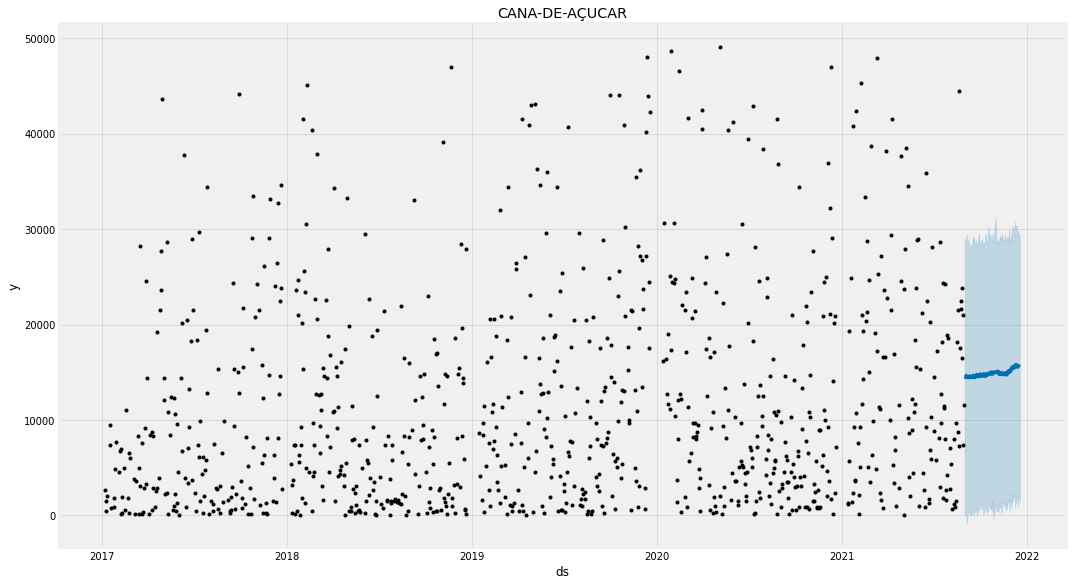

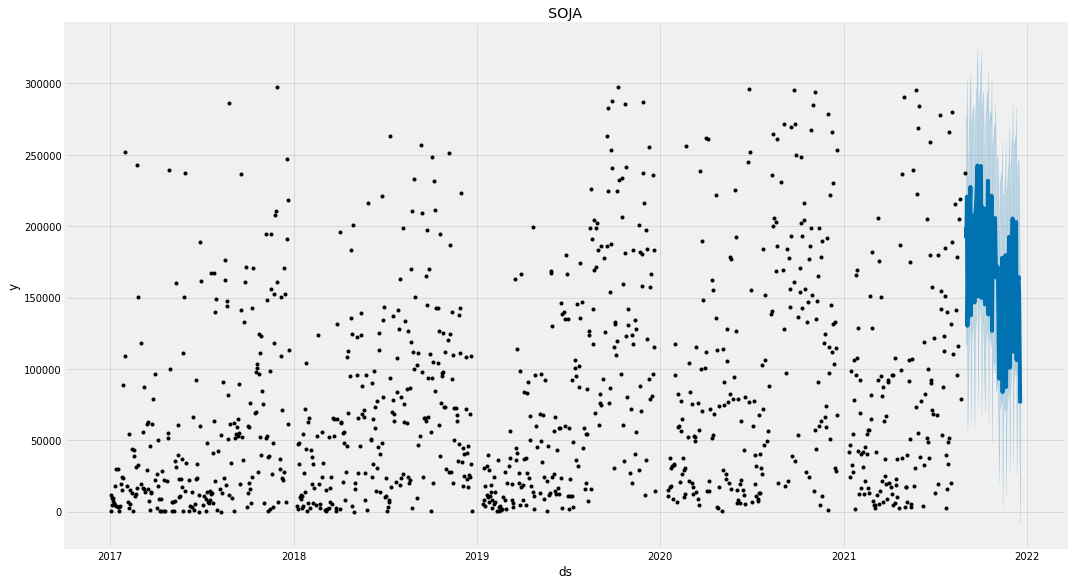

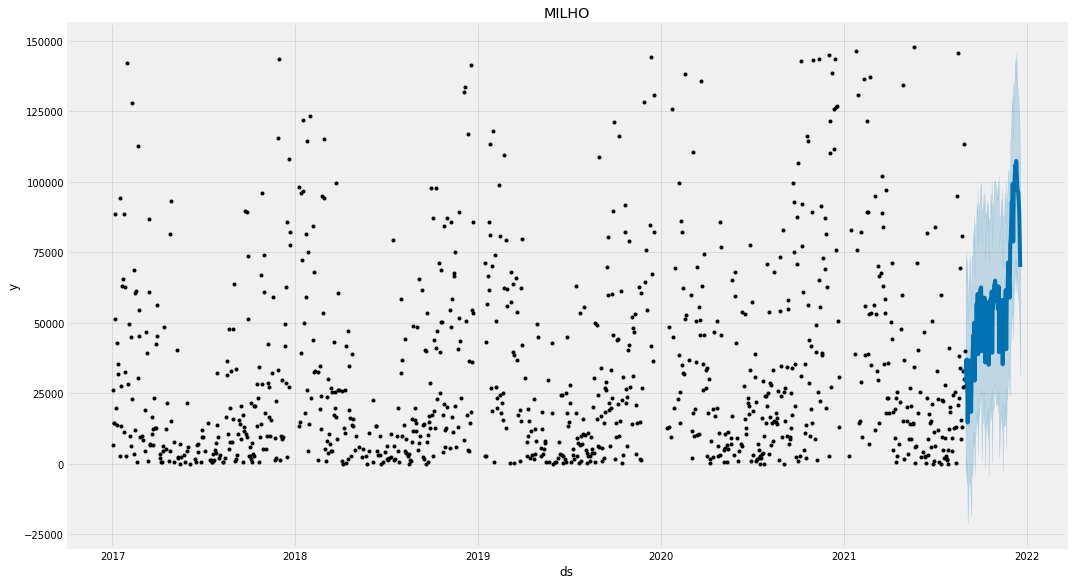

In [ ]:
#Seta cultura como index do Data Frame
df_best = df_best.set_index('ds_cultura')

#treina e testa por cultura o modelo 'tunado'
for cultura in l_cultura:
  
  model_prophet, forecast, df_metrics = tunning_prophet(cultura, train, test, df_best, df_metrics)

  sales_forecast_plot = model_prophet.plot(forecast, figsize=(15,8))  
  ax = sales_forecast_plot.gca()
  ax.set_title(cultura)

  df_cv = performance_cv(model_prophet, initial, prev_days)

  df_p = performance_metrics(df_cv)

  print(cultura, "\n",df_p.mean().to_frame())
  
  plot_components_plotly(model_prophet, forecast)

## NEURAL PROPHET

### Modelo Básico

In [ ]:
def basic_neural_prophet(cat, df_train, df_test, df_metrics):

  df_train = df_train[df_train.ds_cultura == cat].groupby('data').qt_volume.sum().reset_index()
  df_train.columns = ["ds", "y"]
  
  df_test = df_test[df_test.ds_cultura == cat].groupby('data').qt_volume.sum().reset_index()
  df_test.columns = ["ds", "y"]

  model = NeuralProphet()

  periods  = len(df_test)

  metrics  = model.fit(df_train, freq="D", epochs=1000)
  future   = model.make_future_dataframe( df_train, periods=periods, n_historic_predictions=True)
  forecast = model.predict(future)

 
  #Avaliação do modelo
  df_concat = pd.concat([df_train, df_test]).reset_index()
  df_metrics = metrics_aval(df_metrics, 'BASIC_NEURAL_PROPHET', cat, y_true=df_concat.y, y_pred=forecast.yhat1)

  return model, forecast, df_metrics

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16


  0%|          | 0/249 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.57E-02, min: 1.10E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.57E-02, min: 1.10E+00


  0%|          | 0/249 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.57E-02, min: 1.19E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.57E-02, min: 1.19E+00


  0%|          | 0/249 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.23E-02, min: 1.19E+00
INFO:NP.utils_torch:lr-range-test results: steep: 8.23E-02, min: 1.19E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.78E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 7.78E-02
Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:46<00:00,  9.43it/s, SmoothL1Loss=0.0424, MAE=8.22e+3, RMSE=1.03e+4, RegLoss=0]
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32


  0%|          | 0/251 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.79E-02, min: 1.58E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.79E-02, min: 1.58E+00


  0%|          | 0/251 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.38E-02, min: 1.24E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.38E-02, min: 1.24E+00


  0%|          | 0/251 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.79E-02, min: 2.03E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.79E-02, min: 2.03E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.98E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 6.98E-02
Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:08<00:00, 14.51it/s, SmoothL1Loss=0.0337, MAE=4.75e+4, RMSE=6.07e+4, RegLoss=0]
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32


  0%|          | 0/250 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.68E-02, min: 1.32E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.68E-02, min: 1.32E+00


  0%|          | 0/250 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.73E-02, min: 8.01E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.73E-02, min: 8.01E-01


  0%|          | 0/250 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.07E-02, min: 9.46E-01
INFO:NP.utils_torch:lr-range-test results: steep: 6.07E-02, min: 9.46E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.73E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 4.73E-02
Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:06<00:00, 14.99it/s, SmoothL1Loss=0.0358, MAE=2.18e+4, RMSE=2.82e+4, RegLoss=0]


Model         Cultura       MAE      RMSE       Categoria
0                XGBOOST  CANA-DE-AÇUCAR  11102.70  14075.16             NaN
1                XGBOOST            SOJA  60755.23  73172.46             NaN
2                XGBOOST           MILHO  30636.18  37867.43             NaN
3          BASIC_PROPHET  CANA-DE-AÇUCAR  11996.23  14637.69             NaN
4          BASIC_PROPHET            SOJA  64853.18  78285.18             NaN
5          BASIC_PROPHET           MILHO  29168.70  35259.49             NaN
6         MANUAL_PROPHET             NaN  10023.19  12171.53  CANA-DE-AÇUCAR
7         MANUAL_PROPHET             NaN  60615.75  75201.76            SOJA
8         MANUAL_PROPHET             NaN  24042.82  32133.43           MILHO
9         TUNING_PROPHET  CANA-DE-AÇUCAR  12209.88  14356.51             NaN
10        TUNING_PROPHET            SOJA  72856.73  88868.45             NaN
11        TUNING_PROPHET           MILHO  30436.08  36738.06             NaN
12  BASIC_NEURAL_PROPHET  CANA-DE-AÇUCAR   8645.39  10998.79             NaN
13  BASIC_NEURAL_PROPHET            SOJA  49592.10  64270.53             NaN
14  BASIC_NEURAL_PROPHET           MILHO  22556.89  29455.72             NaN

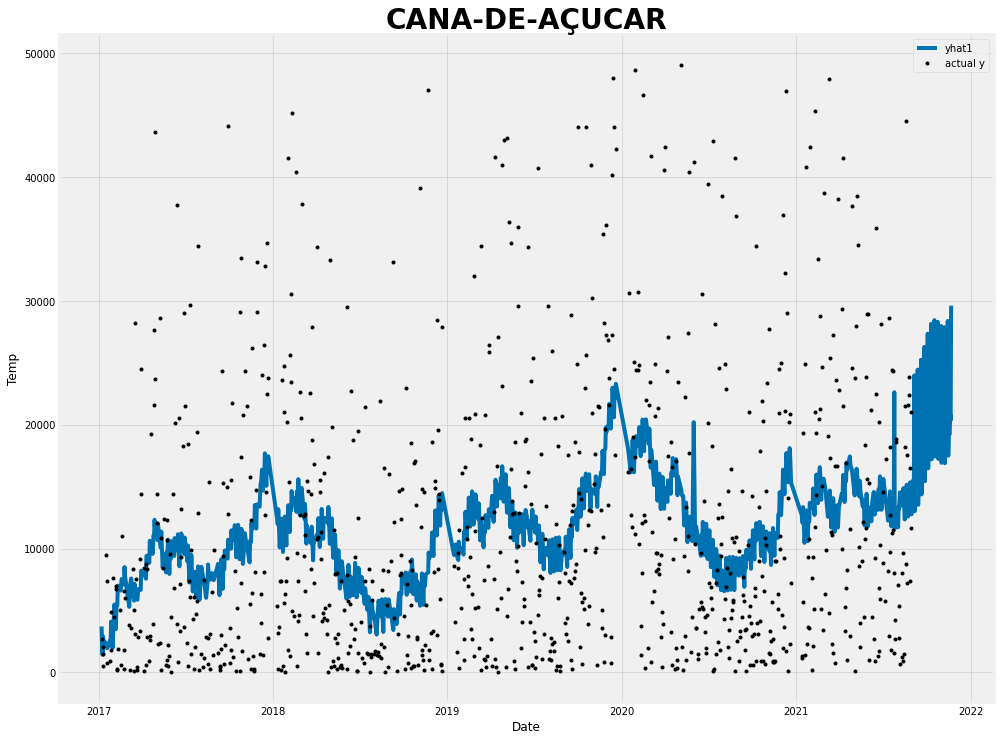

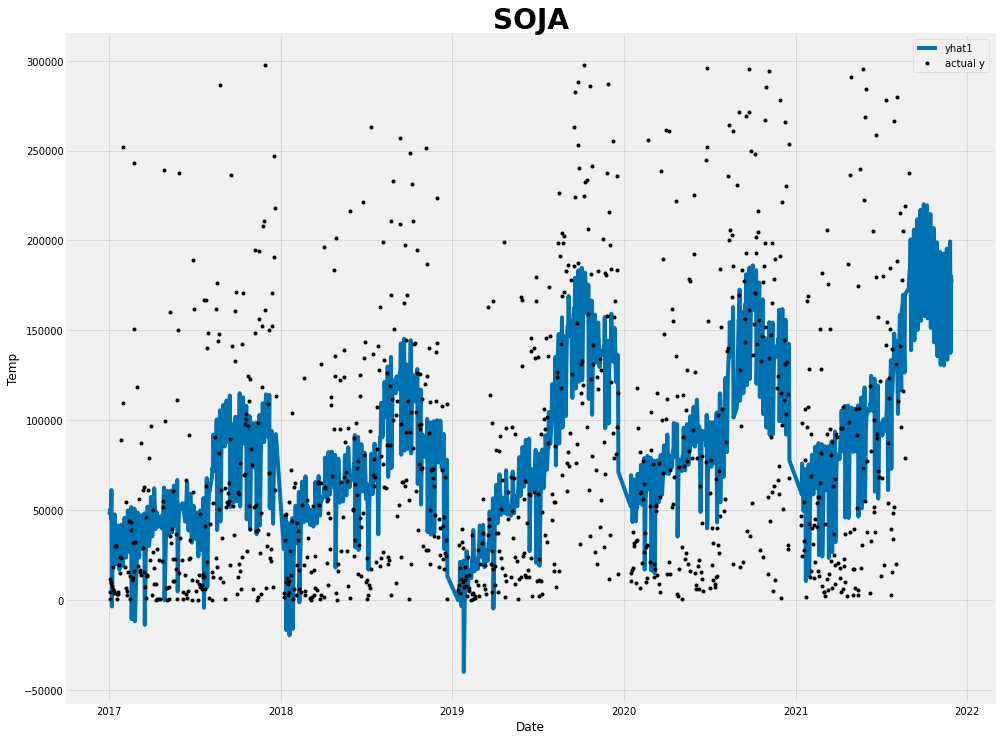

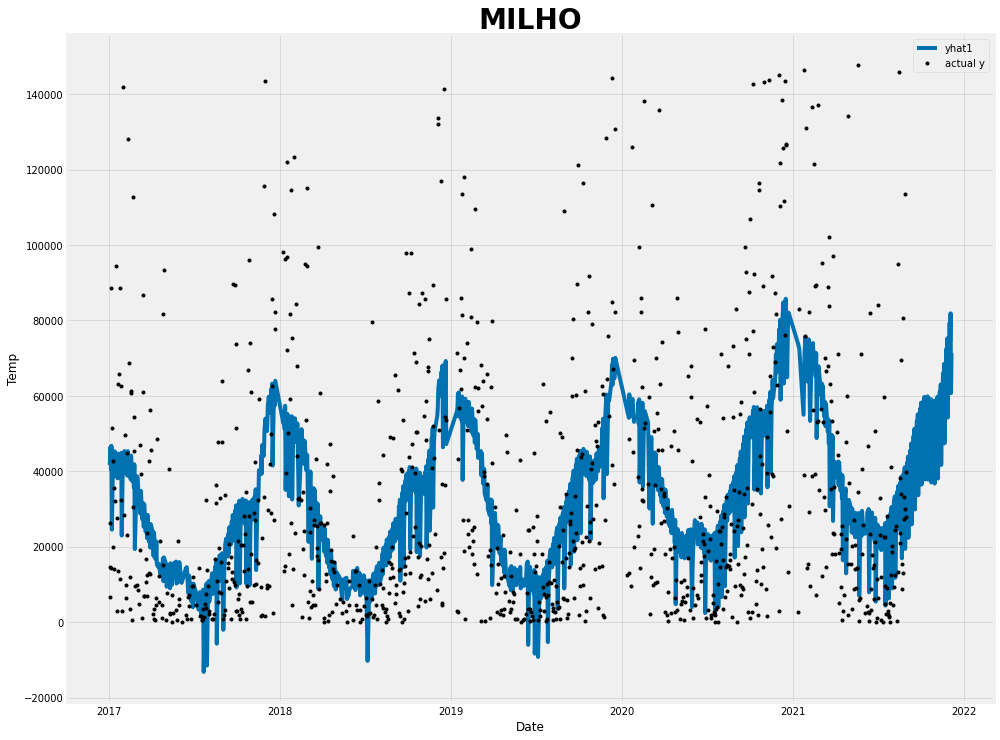

In [ ]:
for categoria in l_cultura:
  
  model, forecast, df_metrics = basic_neural_prophet(categoria, train, test, df_metrics)

  fig, ax = plt.subplots(figsize=(14, 10))
  model.plot(forecast, xlabel="Date", ylabel="Temp", ax=ax)
  ax.set_title(categoria, fontsize=28, fontweight="bold")

df_metrics  

### Ajustando de hiperparâmetros

In [ ]:
def tuning_neural_prophet(cat, df_train, df_test, df_metrics):

  df_train = df_train[df_train.ds_cultura == cat].groupby('data').qt_volume.sum().reset_index()
  df_train.columns = ["ds", "y"]
  
  df_test = df_test[df_test.ds_cultura == cat].groupby('data').qt_volume.sum().reset_index()
  df_test.columns = ["ds", "y"]

  model = NeuralProphet(
    n_forecasts=365,
    batch_size=64,
    epochs=1000,
    learning_rate=0.03
  )

  periods = len(df_test)
  metrics = model.fit(df_train, freq="D", epochs=1000)
  future = model.make_future_dataframe(df_train, periods=periods, n_historic_predictions=True)
  forecast = model.predict(future)

  #Avaliação do modelo
  df_concat = pd.concat([df_train, df_test]).reset_index()
  df_metrics = metrics_aval(df_metrics, 'TUNNING_NEURAL_PROPHET', cat, y_true=df_concat.y, y_pred=forecast.yhat1)

  return model, forecast, df_metrics

WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:38<00:00, 26.29it/s, SmoothL1Loss=0.0424, MAE=8.22e+3, RMSE=1.04e+4, RegLoss=0]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:41<00:00, 24.16it/s, S

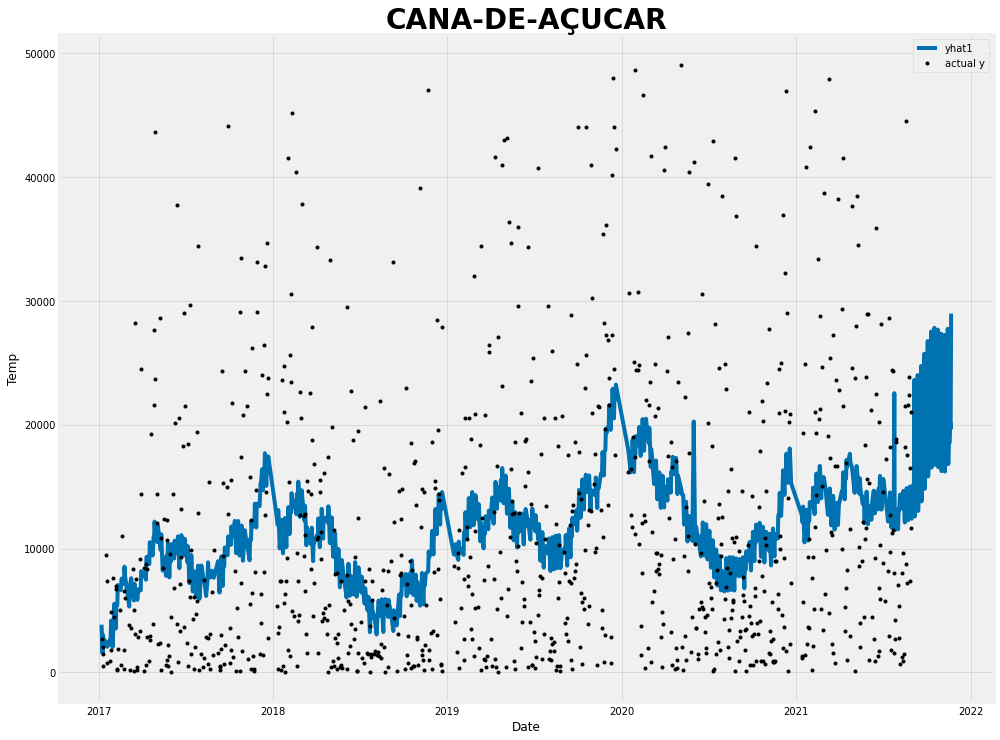

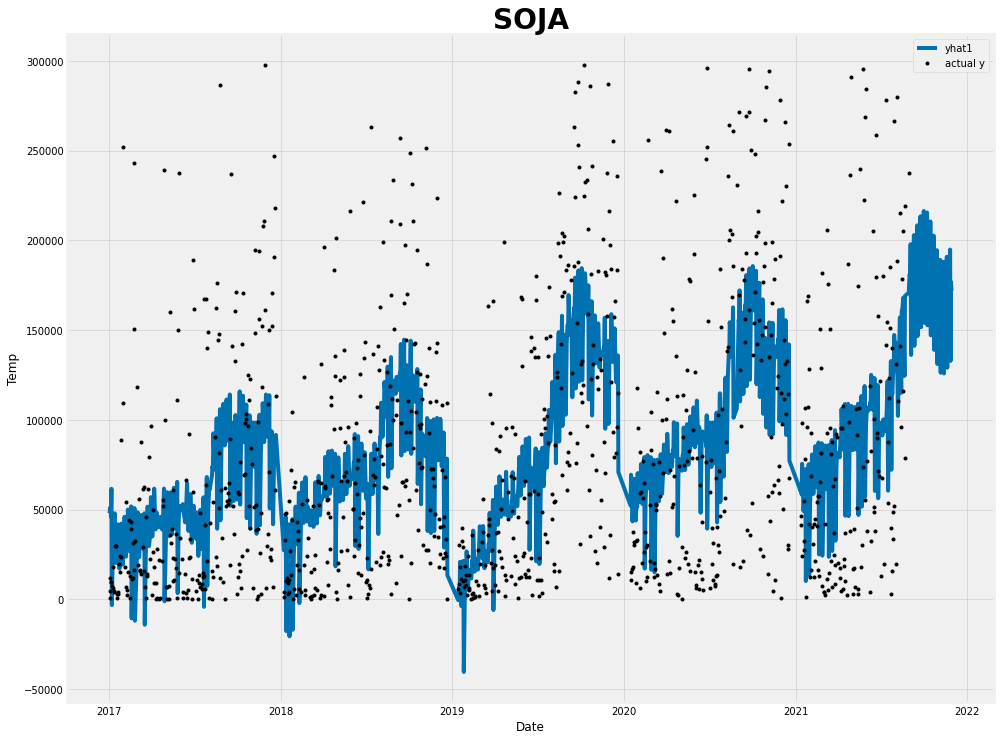

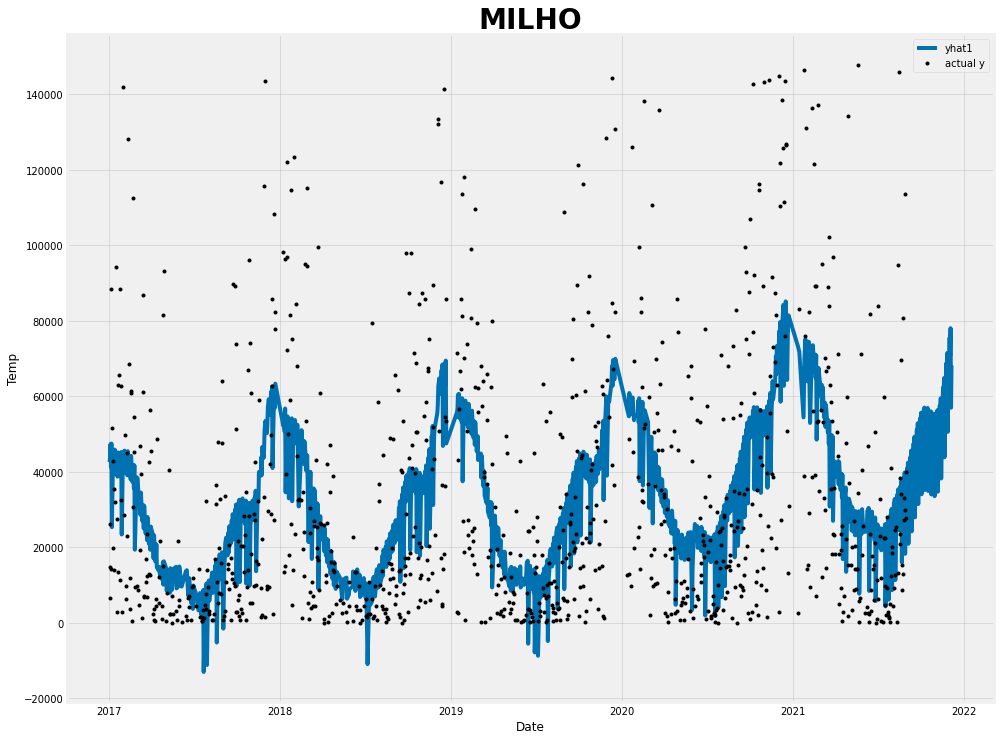

In [ ]:
for categoria in l_cultura:
  
  model, forecast, df_metrics = tuning_neural_prophet(categoria, train, test, df_metrics)

  fig, ax = plt.subplots(figsize=(14, 10))
  model.plot(forecast, xlabel="Date", ylabel="Temp", ax=ax)
  ax.set_title(categoria, fontsize=28, fontweight="bold")  

#Resultados

In [ ]:
df_metrics

Model         Cultura       MAE      RMSE
0                  XGBOOST  CANA-DE-AÇUCAR  11102.70  14075.16
1                  XGBOOST            SOJA  60755.23  73172.46
2                  XGBOOST           MILHO  30636.18  37867.43
3            BASIC_PROPHET  CANA-DE-AÇUCAR  11996.23  14637.69
4            BASIC_PROPHET            SOJA  64853.18  78285.18
5            BASIC_PROPHET           MILHO  29168.70  35259.49
6           MANUAL_PROPHET  CANA-DE-AÇUCAR  10023.19  12171.53
7           MANUAL_PROPHET            SOJA  60615.75  75201.76
8           MANUAL_PROPHET           MILHO  24042.82  32133.43
9           TUNING_PROPHET  CANA-DE-AÇUCAR  12209.88  14356.51
10          TUNING_PROPHET            SOJA  72856.73  88868.45
11          TUNING_PROPHET           MILHO  30436.08  36738.06
12    BASIC_NEURAL_PROPHET  CANA-DE-AÇUCAR   8645.39  10998.79
13    BASIC_NEURAL_PROPHET            SOJA  49592.10  64270.53
14    BASIC_NEURAL_PROPHET           MILHO  22556.89  29455.72
15  TUNNING_NEURAL_PROPHET  CANA-DE-AÇUCAR   8637.26  10988.63
16  TUNNING_NEURAL_PROPHET            SOJA  49417.22  63965.14
17  TUNNING_NEURAL_PROPHET           MILHO  22529.73  29461.66
18  TUNNING_NEURAL_PROPHET  CANA-DE-AÇUCAR   8634.33  10984.65
19  TUNNING_NEURAL_PROPHET            SOJA  49456.37  64032.96
20  TUNNING_NEURAL_PROPHET           MILHO  22525.78  29467.94